# Final Project
Submitted by: [... ***Chen Panker - 315877563, Amitay Tsinis - 311238745*** ...]
## Classification of histopathology images

## Imports

In [47]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
import tensorflow_hub as hub


# Helper libraries
import numpy as np
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from seaborn import heatmap 

import cv2

print(tf.__version__)

2.5.0


## Helping Functions

**draw_loss_and_accuracy (history)** -

given history of model fit, draw a loss and accuracy graphs

In [2]:
def draw_loss_and_accuracy(history):
  plt.figure(figsize=(14,4))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'],':r',label='Train')
  plt.plot(history.history['val_loss'],'r',label='Test')
  plt.title('Loss',fontsize=14)
  plt.xlabel('Epochs',fontsize=14)
  plt.legend()
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'],':b',label='Train')
  plt.plot(history.history['val_accuracy'],'b',label='Test')
  plt.ylim([0, 1])
  plt.title('Accuracy',fontsize=12)
  plt.xlabel('Epochs',fontsize=12)
  plt.legend()
  plt.grid()

**preview_dataset(dataset)** -

given dataset object draws a 12 examples from the dataset and there's matching label.

In [3]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        label = get_label_name(label.numpy())
        plt.title('%s' % label)
        plt.imshow(image.numpy())

**start_points(size, split_size, overlap=0)** -

This function creates list of points which inidicates where to split the image.

In [4]:
def start_points(size, split_size, overlap=0):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points

**split_images(img)** - 

This function get a img and split it into small images of 150X150 shape (can be changed).

In [5]:
def split_images(img):
  img_h, img_w, _ = img.shape
  split_width = 150
  split_height = 150
  splits = []

  X_points = start_points(img_w, split_width, 0.5)
  Y_points = start_points(img_h, split_height, 0.5)

  for i in Y_points:
    for j in X_points:
        split = img[i:i+split_height, j:j+split_width]
        splits.append(split)

  return splits        

**get_color_by_label(label)** -

Returns the color of the given label(as number)

In [65]:
colors=[[255,51,51], #tumor
        [102,204,0], #stroma
        [255,153,51], #complex
        [0,128,255], #lympho
        [153,0,153], #debris
        [255,204,229], #mucosa
        [160,160,160], #adipose
        [64,64,64]] #empty

def get_color_by_label(label):
  return colors[label]

**classify_image(image, yhat)** -

Given image and yhat array, returns an image with the same size, but every patch(shaped 150X150) colored in the matching color depends on the yhat result.

In [7]:
def classify_image(image, yhat):
  split_width = 150
  split_height = 150
  final_image = np.zeros_like(image)

  X_points = start_points(image.shape[0], split_width, 0.5)
  Y_points = start_points(image.shape[1], split_height, 0.5)

  index = 0
  for i in Y_points:
      for j in X_points:
          final_image[i:i+split_width, j:j+split_height] = get_color_by_label(yhat[index])
          index += 1
  
  return final_image

**tumor_heatmap(image, y_hot)** -

Given image and onehot matrix, returns an image with the same size, but every patch(shaped 150X150) colored in the matching tumor probability like heatmap.

In [8]:
def tumor_heatmap(image, y_hot):
  tumor_ep = y_hot[:,0] #extracting tumor propability
  split_width = 150
  split_height = 150
  final_image = np.zeros((5000,5000))
  X_points = start_points(5000, split_width, 0.5)
  Y_points = start_points(5000, split_height, 0.5)

  index = 0
  for i in Y_points:
      for j in X_points:
          final_image[i:i+split_width, j:j+split_height] = tumor_ep[index]
          index += 1

  return final_image

## Getting Started

### Loading the Colorectal histology dataset

In [9]:
(train, train_labels), (test, test_labels) = tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split=['train[:90%]', 'train[90%:]'],
    batch_size=-1,
    shuffle_files=True, 
    as_supervised=True,
))


Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incomplete0WET3Y/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [10]:
# loading again to get the info
(traine, _), info = tfds.load(
    'colorectal_histology',
    split=['train[:90%]', 'train[90%:]'], 
    shuffle_files=True, 
    as_supervised=True,
    with_info=True
)

# function to get label name
get_label_name = info.features['label'].int2str

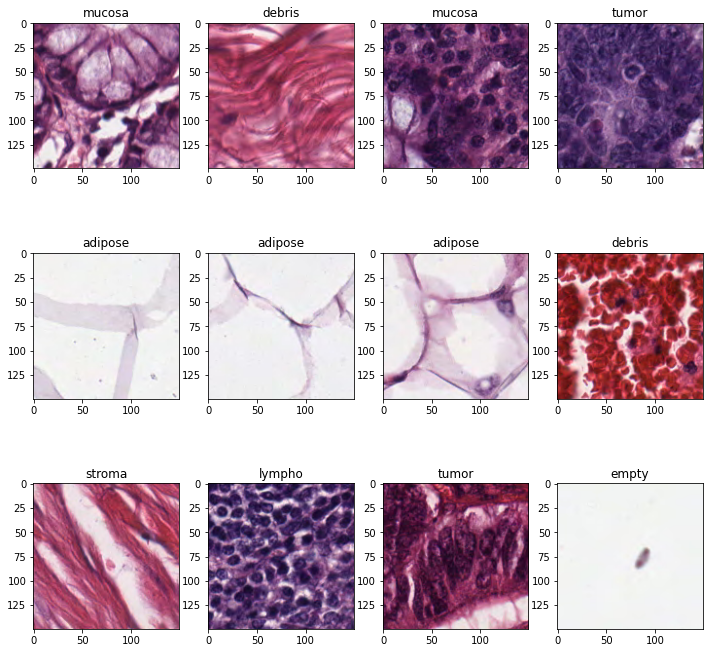

In [14]:
# Preview 12 examples from our dataset
preview_dataset(traine)

In [15]:
NUM_TRAIN_EXAMPLES = train.shape[0]
NUM_TEST_EXAMPLES = test.shape[0]
NUM_CLASSES = info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 4500
Number of TEST examples: 500
Number of label classes: 8


In [16]:
label_map = []
for i in range(8):
  label_map.append(get_label_name(i))
label_map

['tumor',
 'stroma',
 'complex',
 'lympho',
 'debris',
 'mucosa',
 'adipose',
 'empty']

### Pre-processing the dataset

Pre-processing the images and labels of train-set and test-set

In [17]:
# flatten the labels (easier to deal with)
train_labels = train_labels.flatten()  # (4500, 1) -> (4500,)
test_labels = test_labels.flatten()    # (500, 1) -> (500,)

# convert uint8->float32 and normalize range to 0.0-1.0 
train = train.astype('float32') / 255.0
test = test.astype('float32') / 255.0

print("\nAfter pre-processing: ")
print("Train labels: ",train_labels.shape,"\nTest labels: ",test_labels.shape)


After pre-processing: 
Train labels:  (4500,) 
Test labels:  (500,)


### Image Augmentation

First, in order to acheive better results (higher validation accuracy), we will try to use data augmentation.

In [18]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True)

data_iter = datagen.flow(train, train_labels, batch_size=32)


### Trying some models
Trying several schemes in order to find the beset classifier.

#### Own CNN Model

In [ ]:
model = Sequential()
# block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
# block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
# block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
# block 4
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 18, 18, 256)      

In [ ]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
    data_iter,
    validation_data=(test,test_labels),
    steps_per_epoch=train.shape[0]//32,
    epochs=20,
    verbose=0
)

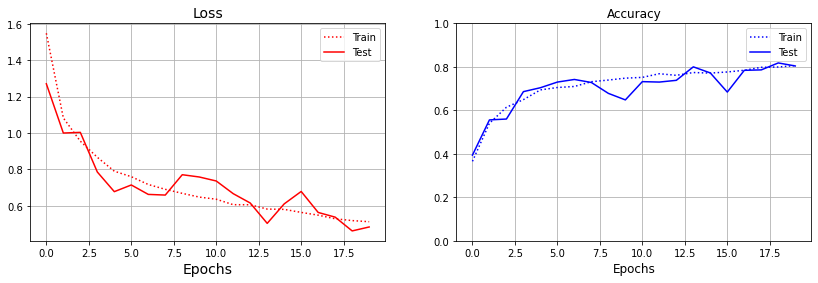

In [ ]:
draw_loss_and_accuracy(history)

In [ ]:
print("Train accuracy:",round(history.history['accuracy'][-1],2))
print("Test accuracy:",round(history.history['val_accuracy'][-1],2))

Train accuracy: 0.81
Test accuracy: 0.8


#### InceptionV3

In [ ]:
base_model = InceptionV3(input_shape = (150, 150, 3),
                         include_top = False,
                         weights = 'imagenet')

base_model.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
inceptionV3_model = Sequential()
inceptionV3_model.add(base_model)
inceptionV3_model.add(Flatten())
inceptionV3_model.add(Dense(1024, activation='relu'))
inceptionV3_model.add(Dropout(0.2))
inceptionV3_model.add(Dense(8, activation='softmax'))

inceptionV3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 8200      
Total params: 40,686,376
Trainable params: 18,883,592
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
inceptionV3_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = inceptionV3_model.fit(
    data_iter,
    validation_data=(test,test_labels),
    steps_per_epoch=train.shape[0]//32,
    epochs=15,
    verbose=0
)

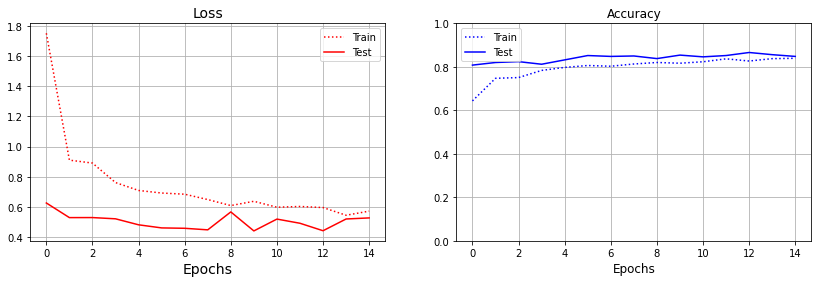

In [ ]:
draw_loss_and_accuracy(history)

In [ ]:
print("Train accuracy:",round(history.history['accuracy'][-1],2))
print("Test accuracy:",round(history.history['val_accuracy'][-1],2))

Train accuracy: 0.84
Test accuracy: 0.85


Let's try fine-tuning the model

In [ ]:
base_model.trainable = True
inceptionV3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 8200      
Total params: 40,686,376
Trainable params: 40,651,944
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9,nesterov=True)

inceptionV3_model.compile(optimizer = sgd_optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = inceptionV3_model.fit(
    data_iter,
    validation_data=(test,test_labels),
    steps_per_epoch=train.shape[0]//32,
    epochs=20,
    verbose=0
)

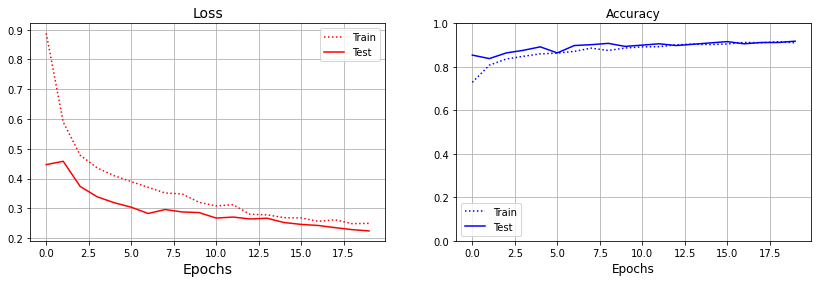

In [ ]:
draw_loss_and_accuracy(history)

In [ ]:
print("Train accuracy:",round(history.history['accuracy'][-1],2))
print("Test accuracy:",round(history.history['val_accuracy'][-1],2))

Train accuracy: 0.91
Test accuracy: 0.92


#### VGG16

In [19]:
# Load the VGG model and set trainable to false
base_model = tf.keras.applications.VGG16(input_shape=(150,150,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

vgg_model = Sequential()
vgg_model.add(base_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(8, activation='softmax'))

vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4104      
Total params: 18,913,608
Trainable params: 4,198,920
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

vgg_model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history_vgg = vgg_model.fit(
    data_iter,
    validation_data=(test,test_labels),
    steps_per_epoch=train.shape[0]//32,
    epochs=15,
    verbose=0
)

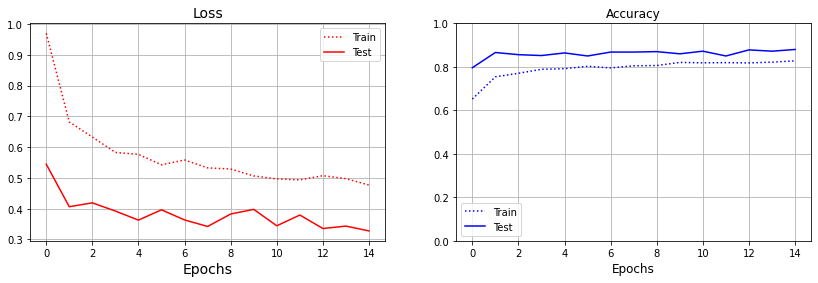

In [22]:
draw_loss_and_accuracy(history_vgg)

In [23]:
print("Train accuracy:",round(history_vgg.history['accuracy'][-1],2))
print("Test accuracy:",round(history_vgg.history['val_accuracy'][-1],2))

Train accuracy: 0.83
Test accuracy: 0.88


Let's try fine-tuning the model

In [24]:
base_model.trainable = True
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4104      
Total params: 18,913,608
Trainable params: 18,913,608
Non-trainable params: 0
_________________________________________________________________


In [25]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9,nesterov=True)

vgg_model.compile(optimizer=sgd_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
history_new = vgg_model.fit(
    data_iter,
    validation_data=(test,test_labels),
    steps_per_epoch=train.shape[0]//32,
    epochs=20,
    verbose=0
)

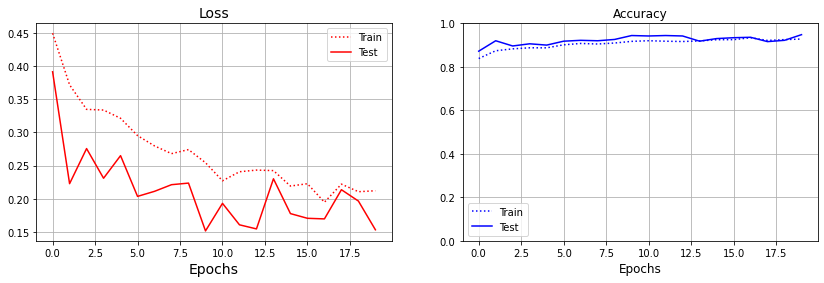

In [27]:
draw_loss_and_accuracy(history_new)

In [28]:
print("Train accuracy:",round(history_new.history['accuracy'][-1],2))
print("Test accuracy:",round(history_new.history['val_accuracy'][-1],2))

Train accuracy: 0.93
Test accuracy: 0.95


#### ResNet50

In [ ]:
base_model = ResNet50(input_shape=(150, 150,3),
                      include_top=False,
                      weights="imagenet")

base_model.trainable = False

resNet50_model = Sequential()
resNet50_model.add(base_model)
resNet50_model.add(Flatten())
resNet50_model.add(Dense(512, activation='relu'))
resNet50_model.add(Dense(8, activation='softmax'))

resNet50_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 4104      
Total params: 49,806,728
Trainable params: 26,219,016
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resNet50_model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = resNet50_model.fit(
    data_iter,
    validation_data=(test,test_labels),
    steps_per_epoch=train.shape[0]//32,
    epochs=15,
    verbose=0
)

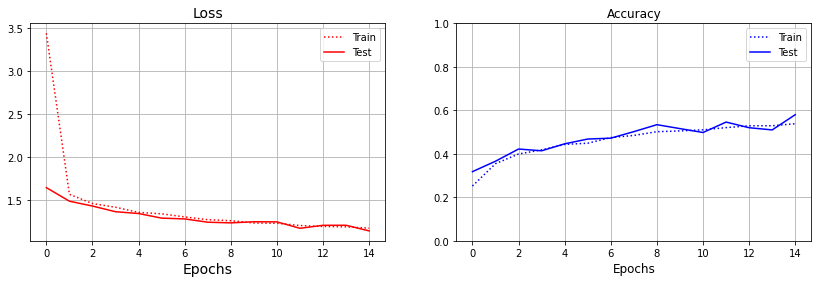

In [ ]:
draw_loss_and_accuracy(history)

In [ ]:
print("Train accuracy:",round(history.history['accuracy'][-1],2))
print("Test accuracy:",round(history.history['val_accuracy'][-1],2))

Train accuracy: 0.54
Test accuracy: 0.58


Let's try fine-tuning the model

In [ ]:
base_model.trainable = True
resNet50_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 4104      
Total params: 49,806,728
Trainable params: 49,753,608
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9,nesterov=True)

resNet50_model.compile(optimizer=sgd_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = resNet50_model.fit(
    data_iter,
    validation_data=(test,test_labels),
    steps_per_epoch=train.shape[0]//32,
    epochs=20,
    verbose=0
)

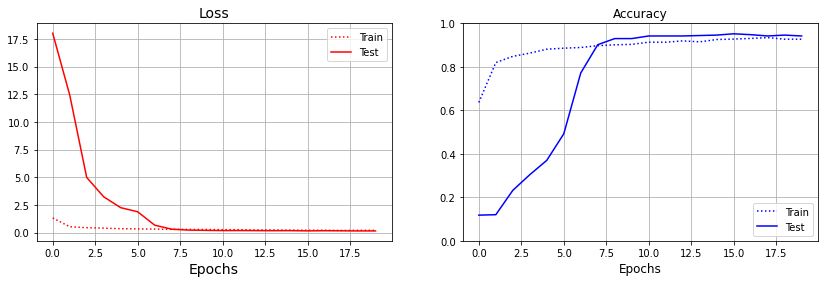

In [ ]:
draw_loss_and_accuracy(history)

In [ ]:
print("Train accuracy:",round(history.history['accuracy'][-1],2))
print("Test accuracy:",round(history.history['val_accuracy'][-1],2))

Train accuracy: 0.93
Test accuracy: 0.94


### Comparing the models

<table>
  <tr>
    <th>Model</th>
    <th>#parameters</th>
    <th>epochs</th>
    <th>train accuracy</th>
    <th>test accuracy</th>
  </tr>
      
  <tr> 
    <td>Own CNN Model</td>   <!-- Model -->
    <td>3,051,528 </td> <!-- #parameters -->
    <td>20</td> <!-- epochs -->
    <td>0.81</td> <!-- train accuracy -->
    <td>0.80</td> <!-- test accuracy -->
  </tr>

  <tr> 
    <td>InceptionV3</td>   <!-- Model -->
    <td>40,651,944 </td> <!-- #parameters -->
    <td>20</td> <!-- epochs -->
    <td>0.92</td> <!-- train accuracy -->
    <td>0.94</td> <!-- test accuracy -->
  </tr>
  <tr> 
    <td>VGG16</td>   <!-- Model -->
    <td>18,913,608 </td> <!-- #parameters -->
    <td>20</td> <!-- epochs -->
    <td>0.93</td> <!-- train accuracy -->
    <td>0.95</td> <!-- test accuracy -->
  </tr>
  <tr> 
    <td>ResNet50</td>   <!-- Model -->
    <td>49,806,728 </td> <!-- #parameters -->
    <td>20</td> <!-- epochs -->
    <td>0.93</td> <!-- train accuracy -->
    <td>0.94</td> <!-- test accuracy -->
  </tr>
    
 
</table>

## The chosen model - VGG16

We used a VGG16 model which gave us validation accuracy of 95% and less parameters .



## Confusion Matrix

In [ ]:
yhat_1hot = vgg_model.predict(test)
yhat_1hot.shape

(500, 8)

In [ ]:
yhat = np.argmax(yhat_1hot, axis=1)
yhat.shape

(500,)

In [ ]:
M = confusion_matrix(test_labels, yhat)
CM = M / M.sum(axis=1) # normalize each row (to sum = 1)

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(CM)

[[ 0.985  0.000  0.015  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.879  0.088  0.000  0.015  0.000  0.000  0.000]
 [ 0.075  0.034  0.824  0.079  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.015  0.984  0.000  0.000  0.000  0.000]
 [ 0.015  0.121  0.015  0.000  0.853  0.000  0.000  0.017]
 [ 0.015  0.000  0.000  0.000  0.000  0.983  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


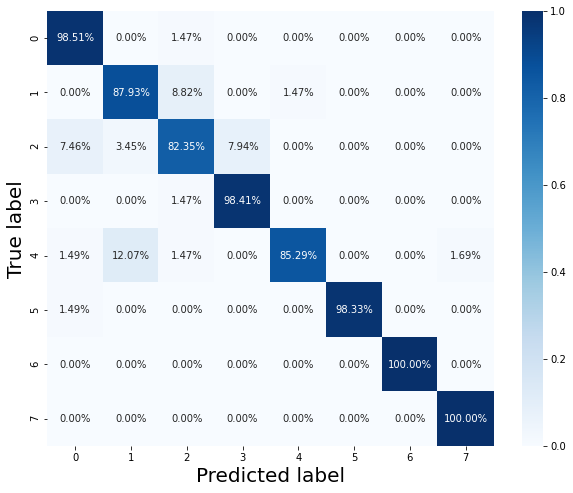

['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']


In [ ]:
plt.figure(figsize=(10,8))
heatmap(CM,cmap='Blues',annot=True, fmt='.2%')
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.show()
print(label_map)

## t-SNE

we used the VGG-16 model (pre-trained on the ImageNet dataset) as a smart feature-extractor. To this aim, we will use its output from the FC layer (fc2) before its last one. This layer produces a 4096-D vector for any given image input of size (150,150,3).

In [ ]:
features_extractor = keras.Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

features = features_extractor.predict(test)

In [ ]:
features_2D = TSNE(n_components=2).fit_transform(features)

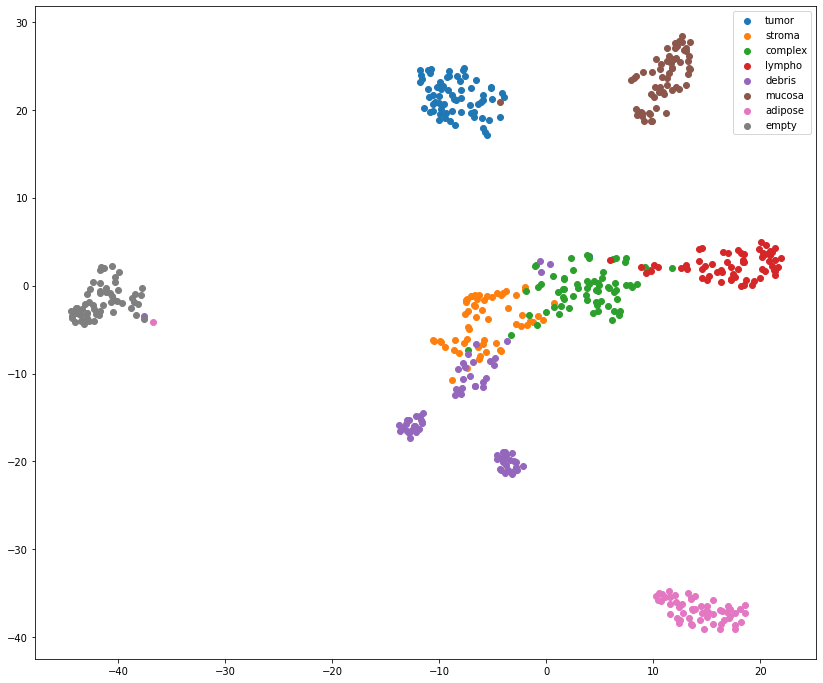

In [ ]:
y = test_labels
plt.figure(figsize=(14,12))
for i in range(NUM_CLASSES):
    X_label = features_2D[np.where(y == i)]
    plt.scatter(X_label[:, 0], X_label[:, 1], label=label_map[i])
plt.legend()
plt.show()

## Loading the Colorectal histology large dataset

In [55]:
large_images = tfds.as_numpy(tfds.load(
    'colorectal_histology_large',
    split=['test'],
    batch_size=-1,
))

large_images = large_images[0]['image']

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology_large/2.0.0.incompleteZY6830/colorectal_histology_large-test.tfrecord


Dataset colorectal_histology_large downloaded and prepared to /root/tensorflow_datasets/colorectal_histology_large/2.0.0. Subsequent calls will reuse this data.


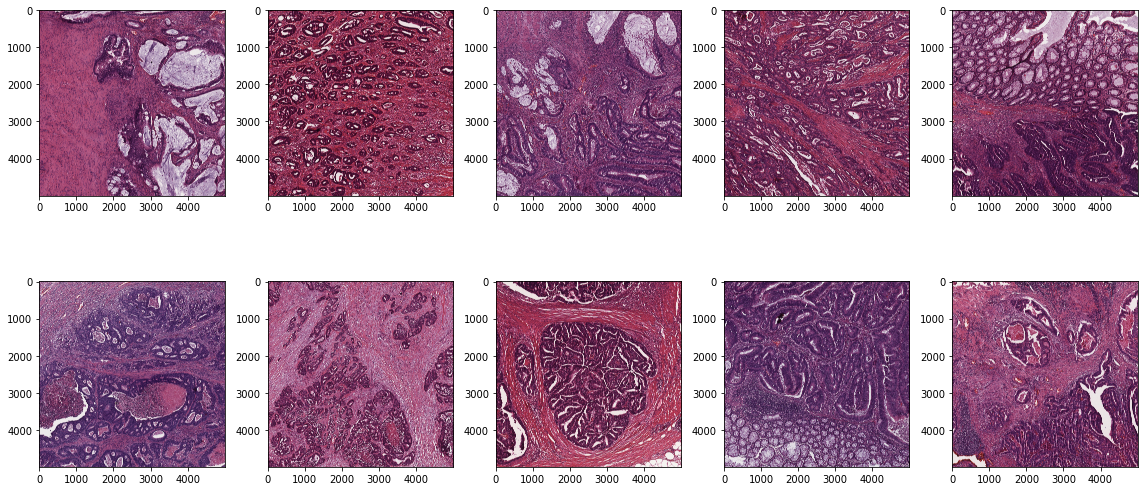

In [56]:
plt.figure(figsize=(16,8))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(large_images[i])
  i+=1

plt.tight_layout()
plt.show()

## Spliting each image into small 150X150 images

In [57]:
splits = split_images(large_images[0])

In [58]:
# normalize range to 0.0-1.0 
splits = np.array(splits) / 255

In [59]:
len(splits)

4356

Preview some of the patches

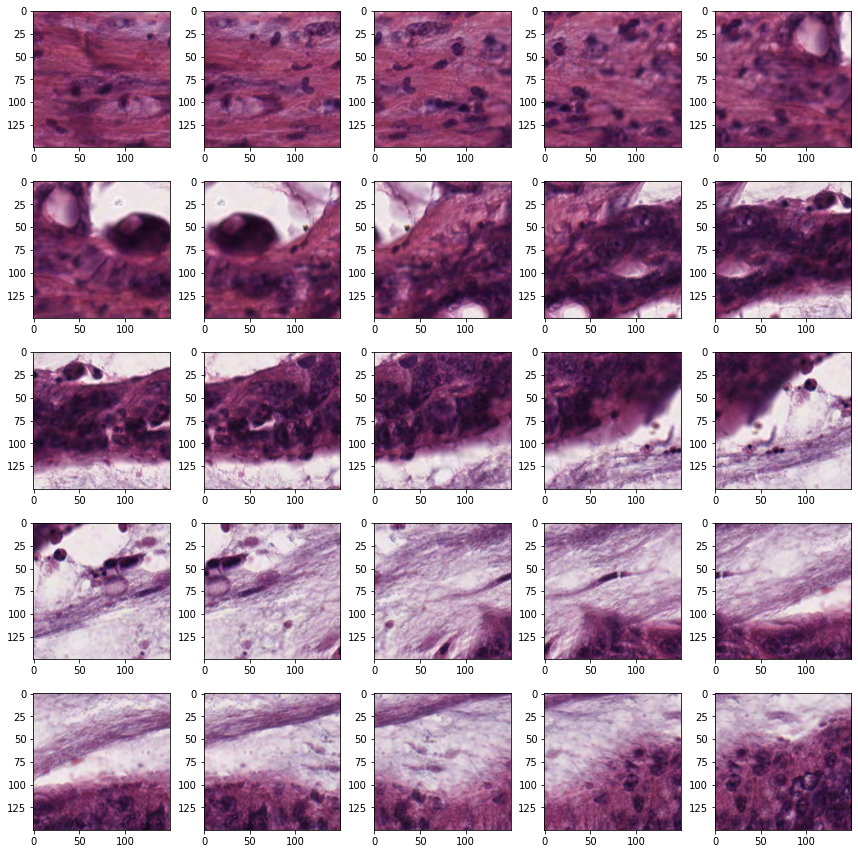

In [60]:
plt.figure(figsize=(12,12))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(splits[i])
  i+=1

plt.tight_layout()
plt.show()

### Classified the large image

In [61]:
y_hot = vgg_model.predict(splits)
yhat = np.argmax(y_hot, axis=1)

In [62]:
classified_image = np.zeros_like(large_images[0])

X_points = start_points(5000, 150, 0.5)
Y_points = start_points(5000, 150, 0.5)

index = 0
for i in Y_points:
    for j in X_points:
        classified_image[i:i+150, j:j+150] = get_color_by_label(yhat[index])
        index += 1

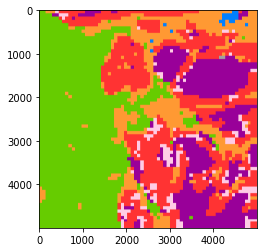

In [64]:
plt.imshow(classified_image)
plt.show()

### 'Heatmap' of the probability value of the “tumor” class

In [ ]:
tumor_ep = y_hot[:,0] # extracting the 'tumor' class probability

In [ ]:
heatmap_image = np.zeros((5000,5000))

In [ ]:
X_points = start_points(5000, 150, 0.5)
Y_points = start_points(5000, 150, 0.5)

index = 0
for i in Y_points:
    for j in X_points:
        heatmap_image[i:i+150, j:j+150] = tumor_ep[index]
        index += 1

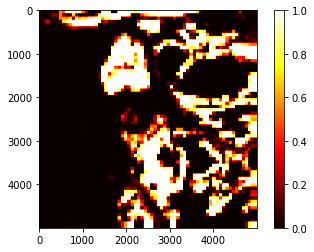

In [ ]:
plt.imshow(heatmap_image,cmap="hot")
plt.colorbar();

Side-by-side

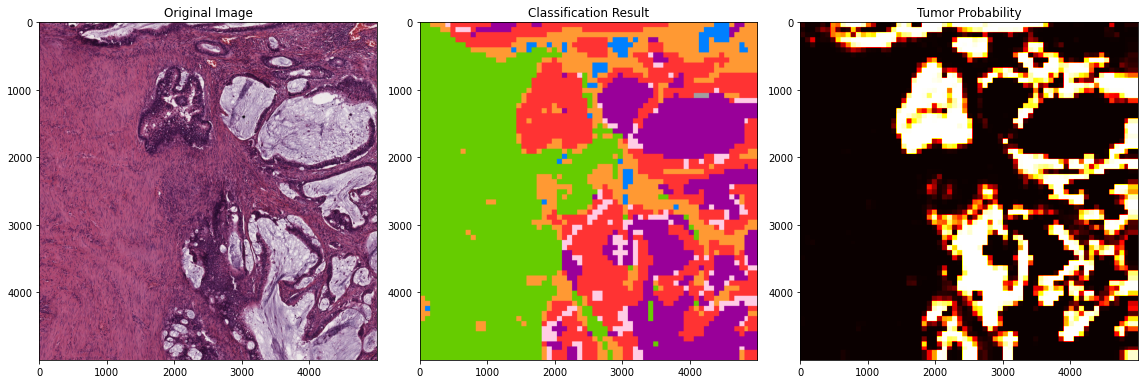

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1), plt.imshow(large_images[0]), plt.title('Original Image')
plt.subplot(1,3,2), plt.imshow(classified_image), plt.title('Classification Result')
plt.subplot(1,3,3), plt.imshow(heatmap_image, cmap='hot'), plt.title('Tumor Probability')
plt.tight_layout()
plt.show()

In [ ]:
vgg_model = tf.keras.models.load_model('vgg_model.h5')
print(vgg_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 4104      
Total params: 18,913,608
Trainable params: 18,913,608
Non-trainable params: 0
_________________________________________________________________
None


## Apply to all 9 images left

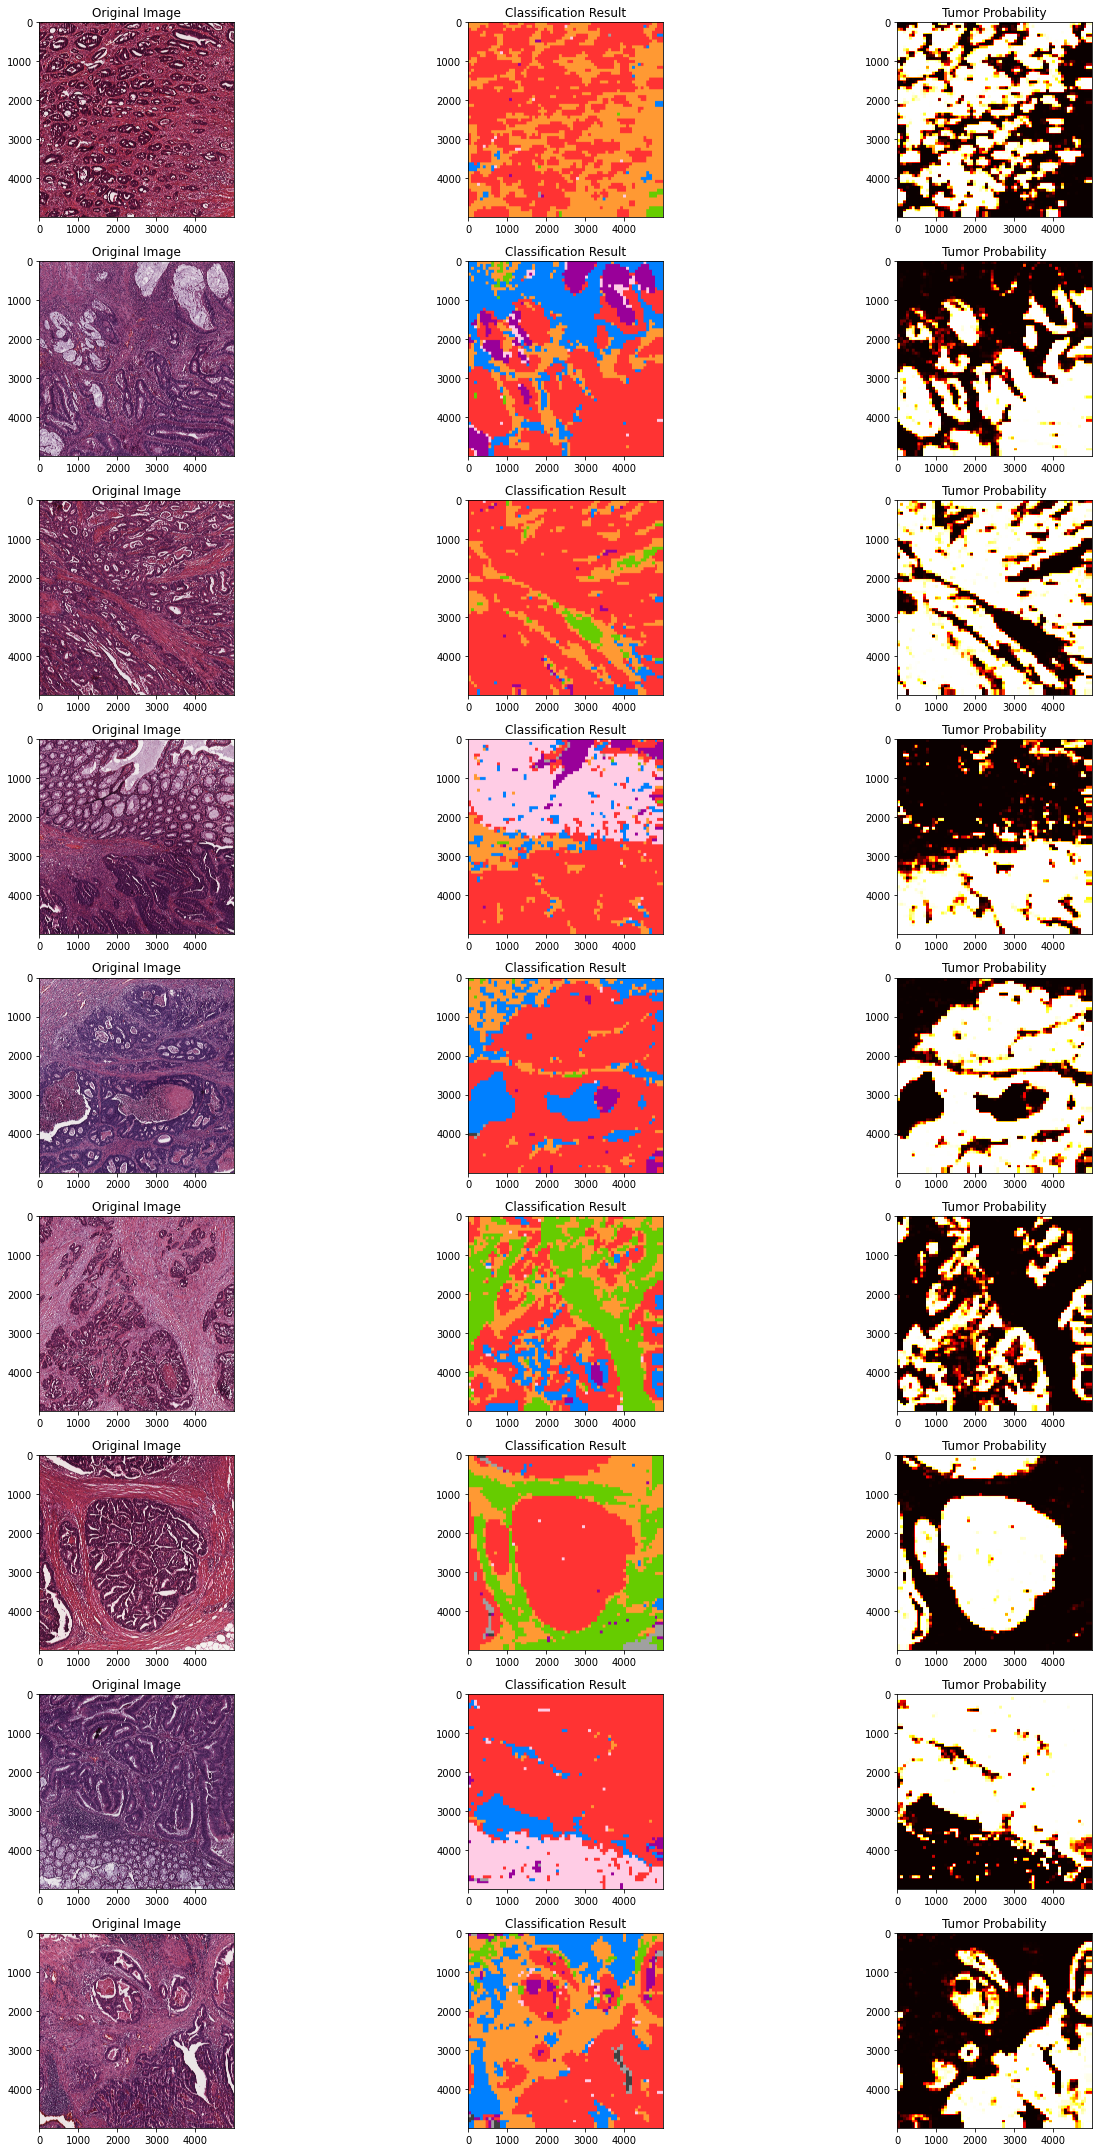

In [ ]:
i = 1
plt.figure(figsize=(20,30))
for large_image in large_images[1:]:
  splits = split_images(large_image) # split one large image into smaller patches of 150X150
  splits = np.array(splits) / 255 # normalize the patches
  yhat_hot = vgg_model.predict(splits) # predict each patch and getting its one hot classification
  yhat = np.argmax(yhat_hot, axis=1) # extract the max probability from the one hot
  classified_image = classify_image(large_image, yhat) # color each patch using the predicted class label
  heatmap_image = tumor_heatmap(large_image, yhat_hot) # color each patch using the probability value of the “tumor” class
  plt.subplot(9,3,i), plt.imshow(large_image), plt.title('Original Image')
  plt.subplot(9,3,i+1), plt.imshow(classified_image), plt.title('Classification Result')
  plt.subplot(9,3,i+2), plt.imshow(heatmap_image,cmap='hot'), plt.title('Tumor Probability')
  i+=3

plt.tight_layout()
plt.show()